**NOTE: This notebook is written for the Google Colab platform. However it can also be run (possibly with minor modifications) as a standard Jupyter notebook.**

In [1]:
#@title -- Installation of Packages -- { display-mode: "form" }
import sys
!{sys.executable} -m pip install lapjv

  Created wheel for lapjv: filename=lapjv-1.3.1-cp36-cp36m-linux_x86_64.whl size=83771 sha256=39b30b00b5d0fd56fdd313998b4ebfa97de22954b49ab8c01c4d7828efa784aa
  Stored in directory: /root/.cache/pip/wheels/6e/fe/fd/b700bd67e00bcd65241d55d875eec17892a86ca6a4deef9515
Successfully built lapjv


In [0]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from lapjv import lapjv
from umap import UMAP
import pandas as pd
import numpy as np
import csv

In [3]:
#@title -- Downloading Data -- { display-mode: "form" }
!mkdir -p data
!wget -nc -O data/en.vec https://www.dropbox.com/s/3isgpiuxpx645tw/en.vec?dl=1
!wget -nc -O data/words_en https://www.dropbox.com/s/qtwxtuvoiwb77tx/words_en?dl=1

--2020-05-14 17:53:41--  https://www.dropbox.com/s/3isgpiuxpx645tw/en.vec?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/3isgpiuxpx645tw/en.vec [following]
--2020-05-14 17:53:41--  https://www.dropbox.com/s/dl/3isgpiuxpx645tw/en.vec
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca297a36199e13d984d54a3a3ea.dl.dropboxusercontent.com/cd/0/get/A3v2HWAXulJBxpm3NvyZJEJakMX1sdCjhpONQHllPatgAIhZz9Wd3O3BXYztBd3KlMi0H-gRFBD9jTC39i0o1TmQLdWB_YHBQXuoANC6uMa1pql_Xrq2nV2IrwlfNXja2qY/file?dl=1# [following]
--2020-05-14 17:53:41--  https://uca297a36199e13d984d54a3a3ea.dl.dropboxusercontent.com/cd/0/get/A3v2HWAXulJBxpm3NvyZJEJakMX1sdCjhpONQHllPatgAIhZz9Wd3O3BXYztBd3KlMi0H-gRFBD9jTC39i0o1TmQLdWB_YHBQXuoANC6uMa1pql_Xrq2nV2IrwlfNXja2q

# Word Embeddings

In this notebook we are going to deal with the topic of word embeddings, i.e. mapping individual words into numeric vectors that would at least partially characterize their semantic properties, relationships etc.

One simple approach that can produce such vectors is called *word2vec* and its principle is illustrated in the figure below. A simple, shallow neural network is created and tasked with predicting a word from its context, or vice versa – predicting a context from a word. As a side-effect, the network learns to map the identifier into a vector, which makes such prediction easier. Vectors of words that appear in the same contexts together will likely be similar.

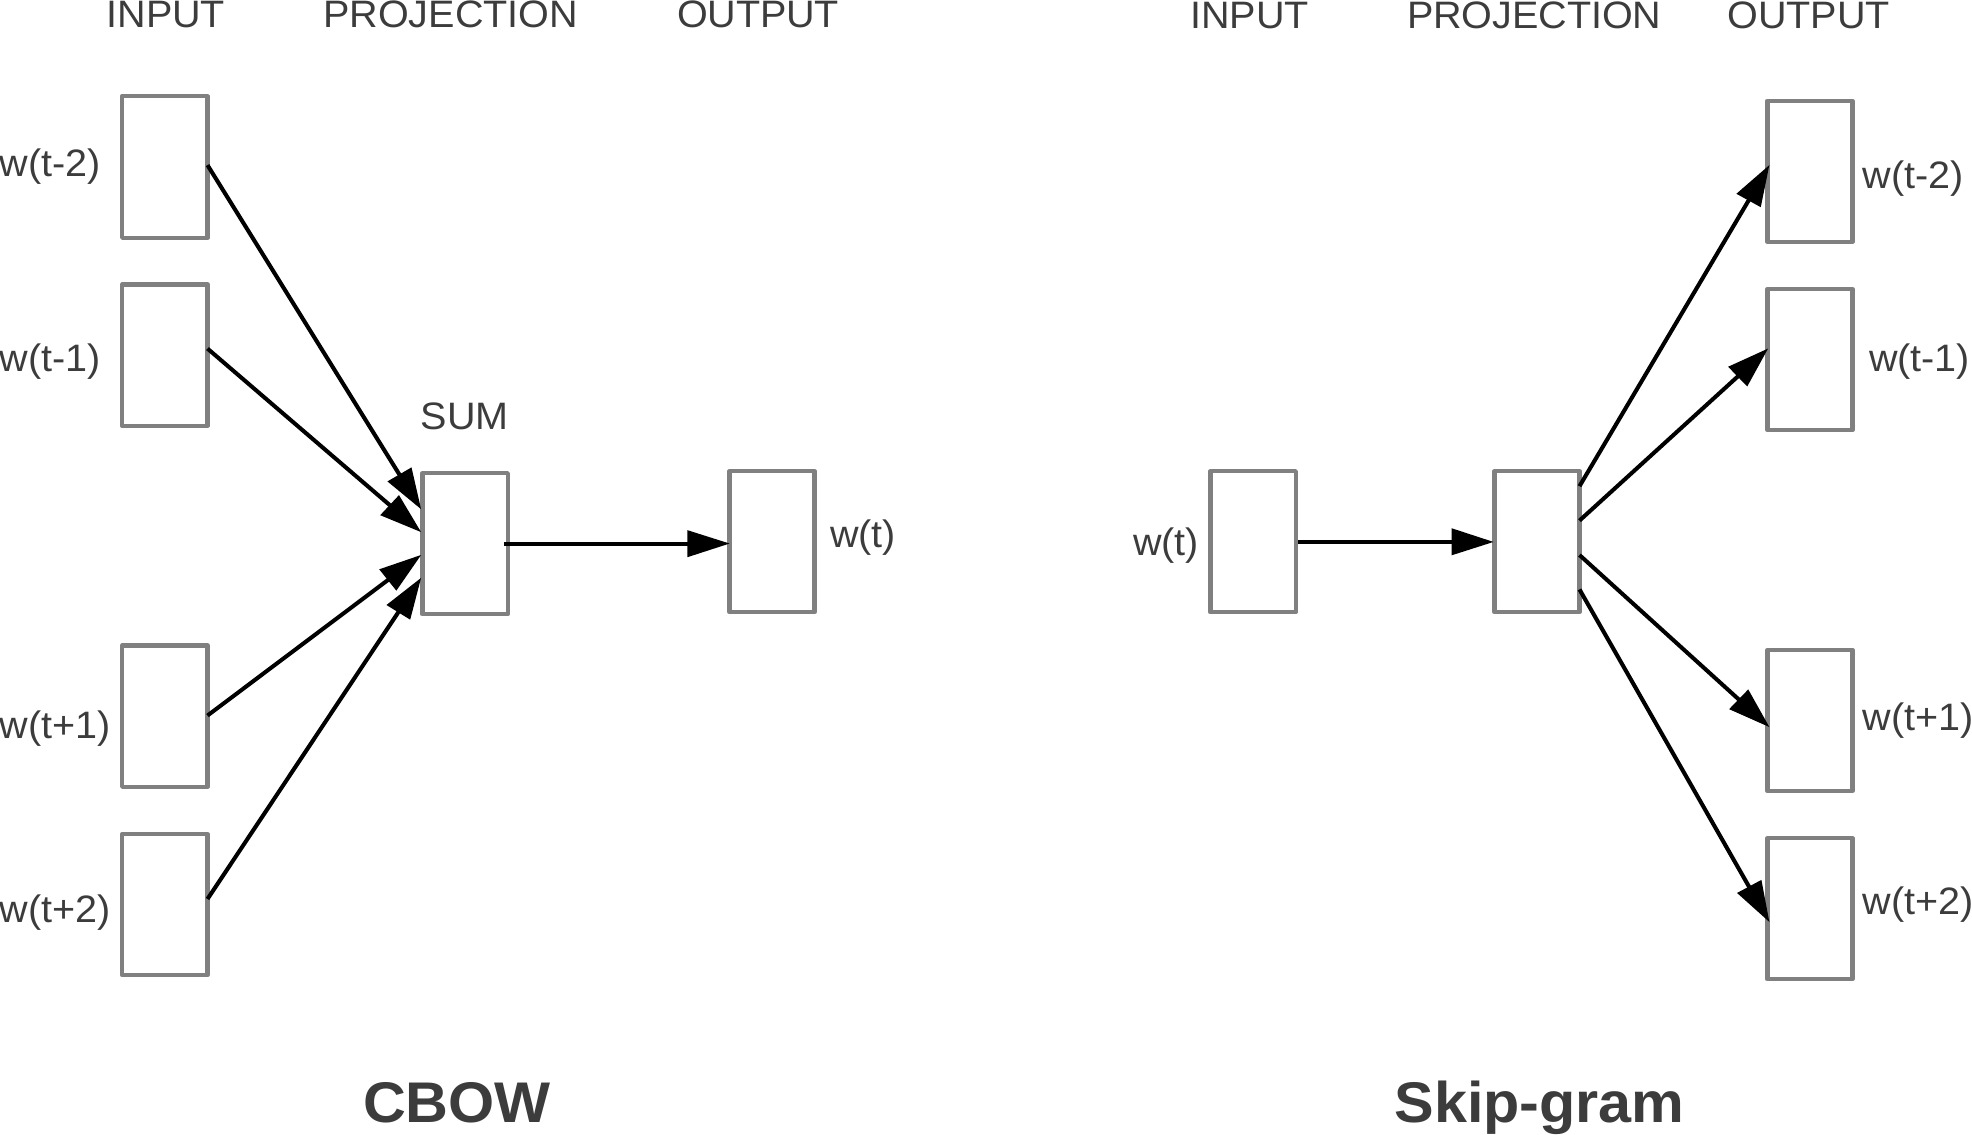

## FastText Vectors

Vectors, which we will be using in this notebook have not been produced by word2vec, but using a method from Facebook called FastText. The links to the relevant papers are available at [the official project website](https://fasttext.cc/).

Pre-trained vectors are available for a large number of languages, including e.g.:
* [English](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz).
* [Slovak](https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.sk.300.vec.gz).
* [Other languages](https://github.com/facebookresearch/fastText/blob/master/docs/crawl-vectors.md).

The files containing the vectors have multiple GB, but we do not need them whole. We will use the fact that the words are sorted by their frequency: from the most to the least frequent. We will therefore only need to extract the first $n$ rows from the file. Note, however, that $n$ can be different depending on a language. For languages that involve declension, such as Slovak, there is a number of different variations that each word can take – $n$ will therefore need to be several times higher to cover the same vocabulary size.

## Loading the Vectors

We will start our example by loading the vectors from a file:

In [0]:
df = pd.read_csv("data/en.vec", sep=' ', skiprows=[0],
                 header=None, quoting=csv.QUOTE_NONE,
                 encoding='utf-8')

We will define an auxiliary function, mapping words to their vectors.

In [0]:
def vec(word):
    return df[df.iloc[:, 0].str.lower() \
      == word.lower()].iloc[0, 1:]

We will also load the list of the words that we will be working with from a file.

In [0]:
with open("data/words_en", "r") as word_file:
    words = [w.strip() for w in word_file]

We will next extract their vectors. If any of the words is not found among those that we have vectors for, we will raise an exception (an alternative: if we downloaded the FastText model for our language, we could generate vectors for arbitrary words – even words that are not in full, untrancated list of vectors).

In [0]:
vecs = []

for w in words:
    try:
        vecs.append(vec(w))
    except IndexError:
        print("Word '{}' not found in the index.".format(w))

## Dimensionality Reduction using UMAP

To visualize the word vectors, we reduce their dimensionality to 2 using UMAP.

In [0]:
um = UMAP()
embeds = um.fit_transform(vecs)
embeds -= embeds.min(axis=0)
embeds /= embeds.max(axis=0)

To make the resulting figure more readable, we will try to colour-code words that appear in the same cluster. We will therefore use hierarchical clustering to identify such clusters. To make the clusters more easily recognizable to the clustering algorithm, we will let it see a 10-dimensional representation of the vectors instead of the 2-dimensional version. We will use cosine distance as our distance metric (corrects for the fact that words occur at different frequencies).

In [0]:
um = UMAP(n_components=10)
clust_embeds = um.fit_transform(vecs)
clust = AgglomerativeClustering(10, affinity='cosine',
          linkage='average').fit_predict(clust_embeds)

In the interest of readability, we will create a custom colourmap to ensure that no colour is too bright.

In [0]:
cm = plt.get_cmap('jet', np.max(clust)+1)

def int2color(cl):
    color = np.array(cm(cl))
    if color[:-1].sum() > 1.5:
        color[:-1] = np.maximum(color[:-1] - 0.2, [0, 0, 0])
        
    return color

Now we are finally ready to plot the vectors.

Text(0, 0.5, 'dim 2')

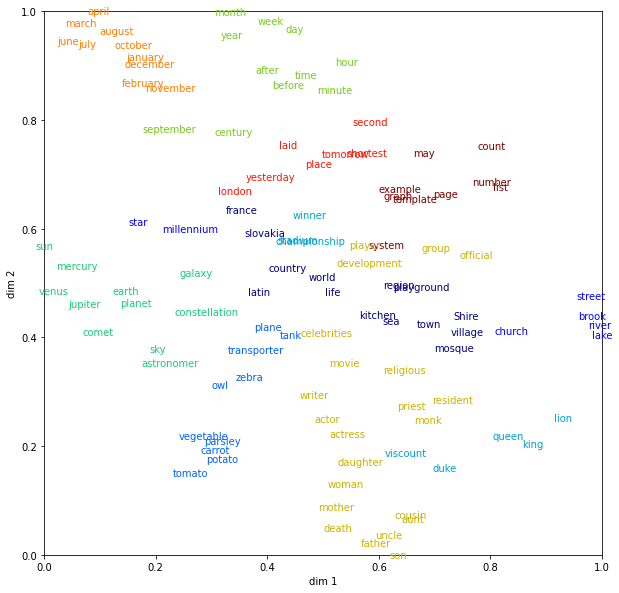

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()

for iw, w in enumerate(words):
    ax.annotate(w, embeds[iw], color=int2color(clust[iw]),
                ha="center", va="center")
    
plt.xlabel("dim 1")
plt.ylabel("dim 2")

## Displaying the Vectors on a Grid using the Jonker-Volgenant Algorithm

The visualization produced by UMAP displays the distances between word vectors and such. However, some of the words may overlap, which makes the figure less readable. We can therefore take an additional step and project all the images onto a regular grid using the Jonker-Volgenant algorithm.

In [0]:
sqrt_size = int(np.ceil(np.sqrt(len(vecs))))
size = sqrt_size * sqrt_size

padded_embeds = np.zeros((size, embeds.shape[1]))
padded_embeds[:embeds.shape[0], :] = embeds
embeds = padded_embeds

grid = np.dstack(np.meshgrid(np.linspace(0, 1, sqrt_size), np.linspace(0, 1, sqrt_size))).reshape(-1, 2)

cost_matrix = cdist(grid, embeds, "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
row_as, col_as, _ = lapjv(cost_matrix)
grid_jv = grid[col_as]

The new positions have been stored in array ``grid_jv``: we will now use them for the plotting.

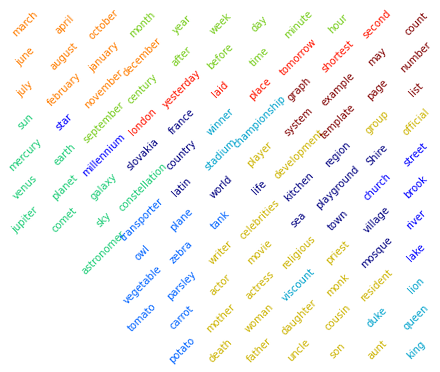

In [13]:
fig = plt.figure(figsize=(7, 6))
plt.axis('off')
ax = plt.gca()
for iw, w in enumerate(words):
    color = np.array(cm(clust[iw]))
    if color[:-1].sum() > 1.5:
        color[:-1] = np.maximum(color[:-1] - 0.2, [0, 0, 0])
    
    ax.annotate(w, grid_jv[iw], color=int2color(clust[iw]),
                rotation=45, ha="center", va="center") 

As the images show, vectors of some related words are indeed grouped in the embedding space: e.g. the names of all the months form a cluster.

## Arithmetic Operations with Vectors

An interesting property of embedding vectors is that arithmetic operations on them sometimes make a surprising amount of sense semantically.

If we perform an operation such as "king" - "man" + "woman", this will yield a vector very close to the embedding of the word "queen". We can verify this using the nearest neighbours algorithm by finding the $k$ nearest neighbours of the new vector.

Let us therefore apply the algorithm to our vectors, again using the cosine distance:

In [0]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm='brute',
        metric='cosine').fit(df.iloc[:, 1:])

We can now test operation "king" - "man" + "woman":

In [15]:
diff = vec("king") - vec("man") + vec("woman")

dist, ind = nbrs.kneighbors(diff.values.reshape((1, -1)))
print(df.iloc[ind[0], 0])

1228           King
2833          Queen
5608       Princess
6804          Kings
8580           Lynn
24423        Regent
32841    Coronation
Name: 0, dtype: object


What we will see is that the word queen si the first or the second (sometimes the nearest neighbour of the new vector will be the original word – king in our case; then queen should come as the second nearest neighbour) nearest word to the new vector.

We can now try the same kind of operation with other concepts, such as capital cities of states.

---
## Task 1: States and Their Capitals

**Test similar vector arithmetic with states and their capital cities. If the results are not robust enough, one can compute the ``diff`` vector as the average for several different combinations of states and capitals – the operation will then work a little more robustly.**

---

In [27]:
diff = vec("Slovakia") - vec("Bratislava") + vec("Lisbon")

dist, ind = nbrs.kneighbors(diff.values.reshape((1, -1)))
print(df.iloc[ind[0], 0])

15639      Lisbon
7564     Portugal
49670      Azores
48961     Algarve
3014        Spain
37248     Madeira
4117       Brazil
Name: 0, dtype: object


---
## Task 2: Inflection of Adjectives

**Test the vector arithmetic on forming comparative and superlative forms of adjectives (e.g. tall, taller, ...).**

---

In [29]:
diff = vec("taller") - vec("tall") + vec("nice")

dist, ind = nbrs.kneighbors(diff.values.reshape((1, -1)))
print(df.iloc[ind[0], 0])

499          nice
13720       nicer
240        better
4637     pleasant
34063    prettier
123          good
158         great
Name: 0, dtype: object
